# Detection Malicious URL Using ML Models

# **Context**
Malicious URLs or malicious website is a very serious threat to cybersecurity. Malicious URLs host unsolicited content (spam, phishing, drive-by downloads, etc.) and lure unsuspecting users to become victims of scams (monetary loss, theft of private information, and malware installation), and cause losses of billions of dollars every year. We have collected this dataset to include a large number of examples of Malicious URLs so that a machine learning-based model can be developed to identify malicious urls so that we can stop them in advance before infecting computer system or spreading through inteinternet.

# **Content**
we have collected a huge dataset of 651,191 URLs, out of which 428103 benign or safe URLs, 96457 defacement URLs, 94111 phishing URLs, and 32520 malware URLs. Figure 2 depicts their distribution in terms of percentage. As we know one of the most crucial tasks is to curate the dataset for a machine learning project. We have curated this dataset from five different sources.

For collecting benign, phishing, malware and defacement URLs we have used [URL dataset (ISCX-URL-2016)](https://www.unb.ca/cic/datasets/url-2016.html) For increasing phishing and malware URLs, we have used [Malware domain black list dataset](http://www.malwaredomains.com/wordpress/?page_id=66). We have increased benign URLs using [faizan git repo](https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs/tree/master/data) At last, we have increased more number of phishing URLs using [Phishtank dataset](https://www.phishtank.com/developer_info.php) and [PhishStorm dataset](https://research.aalto.fi/en/datasets/phishstorm--phishing--legitimate-url-dataset(f49465b2-c68a-4182-9171-075f0ed797d5).html) As we have told you that dataset is collected from different sources. So firstly, we have collected the URLs from different sources into a separate data frame and finally merge them to retain only URLs and their class type.

A URL consists of the top-level domain, hostname, paths, and port of the web
address, as in the following diagram:

![url](https://user-images.githubusercontent.com/70811337/150021474-4ba64b34-1d09-427f-9cf6-25508571d18d.PNG)

<h2 style="width: 100%;
    margin: 0;
    padding: 0;
    text-align: center;">---- Table of contents ----</h2>

1. [Importing Libraries](#1)
2. [Load Dataset](#2)
3. [Meta information of Dataframe](#3)
4. [Checking for NaN values](#4)
5. [Feature Extraction](#5)
6. [Train & Test Split](#6)
7. [Training models](#7)
  <ul>
      <li>✔️ Decision Tree Classifier</li>
      <li>✔️ Random Forest Classifier</li>
      <li>✔️ AdaBoost Classifier</li>
      <li>✔️ KNeighbors Classifier</li>
      <li>✔️ SGD Classifier</li>
      <li>✔️ Extra Trees Classifier</li>
      <li>✔️ Gaussian NB</li>
  </ul>
8. [Final Report](#8)

In [1]:
# extract the domain name from a URL (Extract the top level domain (TLD) from the URL given).

!pip install tld

<a id="1"></a> <br>
# 📥 Importing Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

from colorama import Fore  #Colorama is a module to color the python outputs

from urllib.parse import urlparse
# This module defines a standard interface to break Uniform Resource Locator (URL) 
# strings up in components (addressing scheme, network location, path etc.), 
# to combine the components back into a URL string, 
# and to convert a “relative URL” to an absolute URL given a “base URL.”

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

<a id="2"></a> <br>
# 🗃️ Load Dataset

In [3]:
data = pd.read_csv('../input/malicious-urls-dataset/malicious_phish.csv')
data.head(20)

In [4]:
data2=data.copy()
print(data2)

In [5]:

# deleting the defacements
indexNames = data2[ data2['type'] == 'defacement' ].index
# Delete these row indexes from dataFrame
data2.drop(indexNames , inplace=True)
print(data2)

In [6]:
# deleting the malwares
indexNames = data2[ data2['type'] == 'malware' ].index
# Delete these row indexes from dataFrame
data2.drop(indexNames , inplace=True)
print(data2)

In [7]:
new_line={'url':'apple-iclods.org/', 'type': 'phishing'}
data2.append(new_line, ignore_index=True)
data2.tail()
data2[data2['url']=="apple-iclods.org/"]

In [8]:
data2

**Now with our data2 ; we have only phishing websites and normal ones. Total = 522214**

Website **defacements** are the unauthorized modification of web pages, including the addition, removal, or alteration of existing content. These attacks are commonly carried out by hacktivists, who compromise a website or web server and replace or alter the hosted website information with their own messages.

**Phishing** is a type of social engineering attack often used to steal user data, including login credentials and credit card numbers. It occurs when an attacker, masquerading as a trusted entity, dupes a victim into opening an email, instant message, or text message

**Malware** (short for “malicious software”) is a file or code, typically delivered over a network, that infects, explores, steals or conducts virtually any behavior an attacker wants. And because malware comes in so many variants, there are numerous methods to infect computer systems.

<a id="3"></a> <br>
# 📝 Meta information of Dataframe

In [9]:
data2.info()

<a id="4"></a>
# 🔎 Checking for NaN values

In [10]:
data2.isnull().sum()

In [11]:
count = data2.type.value_counts()
count

In [12]:
x=count.index
x

In [13]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

<h4>first have to omit the (www.) from the URL which is in fact a sub domain in itself.</h4>

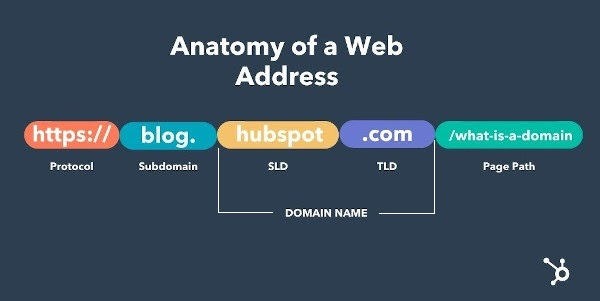

In [14]:
data2['url'] = data2['url'].replace('www.', '', regex=True)
data2


In [15]:
data2.head(10)

In [16]:
rem = {"Category": {"benign": 0,  "phishing":1}}
data2['Category'] = data2['type']
data2 = data2.replace(rem)
data2.head(20)

<a id="5"></a> <br>
# 🦾 Feature Extraction

In [17]:
data2['url_len'] = data2['url'].apply(lambda x: len(str(x)))

In [18]:
data2.head()

In [19]:
def process_tld(url):
    try:
#         Extract the top level domain (TLD) 
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain



# netloc : Contains the network location - which includes the domain itself (and subdomain if present), 
# the port number, along with an optional credentials in form of username:password . Together it may take
# form of username:password@domain.com:80

In [20]:
data2['domain'] = data2['url'].apply(lambda i: process_tld(i))

In [21]:
data2.head()

In [22]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data2[a] = data2['url'].apply(lambda i: i.count(a))

In [23]:
data2.head()

In [46]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    print(hostname)
    hostname = str(hostname)
    print(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
    
    

    

# urlparse():This function parses a URL into six components, returning a 6-tuple. 
# This corresponds to the general structure of a URL. Each tuple item is a string. 
# The components are not broken up in smaller parts 
#(for example, the network location is a single string), and % escapes are not expanded.

In [47]:
abnormal_url('www.hotmail.com.svg')

In [25]:
data2['abnormal_url'] = data2['url'].apply(lambda i: abnormal_url(i))

In [26]:
data2.head(10)

In [27]:
sns.countplot(x='abnormal_url', data=data2);

In [28]:
def httpSecure(url):
    htp = urlparse(url).scheme #It supports the following URL schemes: file , ftp , gopher , hdl , 
                               #http , https ... from urllib.parse
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [29]:
data2['https'] = data2['url'].apply(lambda i: httpSecure(i))

In [30]:
data2.head(20)

In [31]:
sns.countplot(x='https', data=data2);

<h4>Counts the number of digit characters in a URL</h4>

In [32]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [33]:
data2['digits']= data2['url'].apply(lambda i: digit_count(i))

<h4>Counts the number of letter characters in a URL</h4>

In [34]:
data2.head()

In [35]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

# The isalpha() method returns True if all the characters are alphabet letters (a-z). 
# Example of characters that are not alphabet letters: (space)!

In [36]:
data2['letters']= data2['url'].apply(lambda i: letter_count(i))

<h4>Checks to see whether URL contains a shortening service</h4>

In [37]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    

# A URL shortening service is a third-party website that converts that long URL to a short, 
# case-sensitive alphanumeric code. Simply put, this means that a URL shortening service takes 
# ridiculously long URLs (web addresses) and makes them short.

In [38]:
data2['Shortining_Service'] = data2['url'].apply(lambda x: Shortining_Service(x))

In [39]:
data2.head(20)

In [40]:
sns.countplot(x='Shortining_Service', data=data2);

In [41]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [42]:
data2['having_ip_address'] = data2['url'].apply(lambda i: having_ip_address(i))

In [43]:
data2.head()

In [44]:
data2['having_ip_address'].value_counts()

In [45]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

In [ ]:
X = data2.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data2['Category']

In [ ]:
X

In [ ]:
y

<a id="6"></a> <br>
# ✂️ Train & Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
y_train

In [ ]:
y_test

<a id="7"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/32/4149/4149680.png"/> Training models

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

In [ ]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,KNeighborsClassifier,SGDClassifier,
         ExtraTreesClassifier,GaussianNB]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

In [ ]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','KNeighbors Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})

In [ ]:
X_test

In [ ]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

In [ ]:
def URL_Converter(urls):
    data= pd.DataFrame()
    data['url'] = pd.Series(urls)

    
    data['url_len'] = data['url'].apply(lambda x: len(str(x)))
    data['domain'] = data['url'].apply(lambda i: process_tld(i))
    feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
    for a in feature:
        data[a] = data['url'].apply(lambda i: i.count(a))  
    data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))
    data['https'] = data['url'].apply(lambda i: httpSecure(i))
    data['digits']= data['url'].apply(lambda i: digit_count(i))
    data['letters']= data['url'].apply(lambda i: letter_count(i))
    data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))
    data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))
    print(data.columns)
    X = data.drop(['url','domain'],axis=1)
    
    return X
    

In [ ]:
urls= ['hissoulreason.com',
       'unauthorizd.newebpage.com',
'diaryofagameaddict.com',
'espdesign.com.au',
'iamagameaddict.com',
'kalantzis.net',
'slightlyoffcenter.net',
'toddscarwash.com',
'tubemoviez.com',
'ipl.hk',
'crackspider.us/toolbar/install.php?pack=exe',
'pos-kupang.com/',
'rupor.info',
'svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt',
'officeon.ch.ma/office.js?google_ad_format=728x90_as',
'sn-gzzx.com',
'sunlux.net/company/about.html',
'outporn.com',
'timothycopus.aimoo.com',
'xindalawyer.com',
'freeserials.spb.ru/key/68703.htm',
'deletespyware-adware.com',
'orbowlada.strefa.pl/text396.htm',
'ruiyangcn.com',
'zkic.com',
'adserving.favorit-network.com/eas?camp=19320;cre=mu&grpid=1738&tag_id=618&nums=FGApbjFAAA',
'cracks.vg/d1.php',
'juicypussyclips.com',
'nuptialimages.com',
'andysgame.com',
'bezproudoff.cz',
'ceskarepublika.net',
'hotspot.cz',
'gmcjjh.org/DHL',
'nerez-schodiste-zabradli.com',
'nordiccountry.cz',
'nowina.info',
'obada-konstruktiwa.org',
'otylkaaotesanek.cz',
'pb-webdesign.net',
'pension-helene.cz',
'podzemi.myotis.info',
'smrcek.com',
'spekband.com',
'm2132.ehgaugysd.net/zyso.cgi?18',
'webcom-software.ws/links/?153646e8b0a88',
'worldgymperu.com',
'zgsysz.com',
'oknarai.ru',
'realinnovation.com/css/menu.js']

In [ ]:
urls=['https://logistilink.xyz',
     'yurika.otakuthon.com/reg/main.pl/en/',
      'wreathsacrossamerica.org/locations/',
      'apple-search.info',
      'www.itcarezone.com/xlrmp/files/anna.exe'
     ]

In [ ]:
X_train

In [ ]:
test_data= URL_Converter(urls)

In [ ]:
models

In [ ]:
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(test_data)
    print(pred)

**8 - Final Rreport**

In [ ]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','KNeighbors Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})
print(output)

<a id="9"></a> <br>
# ✨ Thanks

* Feel free to download Notebook and do experiments on it.
* Comments if you find something inappropriate and will improve accordingly.
* Upvote if you find this notebook useful.